# Import libraries

In [176]:
import os, shutil
import split_folders
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg


import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2.0.0


# Load data 

In [2]:
original_dataset = os.path.join('/Users/Desktop/malaria','cell_images')
original_dataset_parasitized = os.path.join(original_dataset, 'Parasitized')
original_dataset_uninfected = os.path.join(original_dataset, 'Uninfected')

# Copying images 

In [3]:
# Create a base dir
if not os.path.isdir('healthy_and_infected'):
                base_dir = '/Users/Desktop/malaria/healthy_and_infected'
                os.mkdir(base_dir)

In [4]:
# Make train, valid and test directories
#train
if not os.path.isdir('healthy_and_infected/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('healthy_and_infected/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('healthy_and_infected/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [5]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/inf'):
    infected_trn_dir = os.path.join(train_dir, 'inf')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/inf'):
    infected_valid_dir = os.path.join(valid_dir, 'inf')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('healthy_and_infected/test/inf'):
    infected_test_dir = os.path.join(test_dir, 'inf')
    os.mkdir(infected_test_dir)

In [6]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/healthy'):
    healthy_trn_dir = os.path.join(train_dir, 'healthy')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/healthy'):
    healthy_valid_dir = os.path.join(valid_dir, 'healthy')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('healthy_and_infected/test/healthy'):
    healthy_test_dir = os.path.join(test_dir, 'healthy')
    os.mkdir(healthy_test_dir)

In [7]:
# Copies the first 10981 infected images to the infected_train_dir
fnames = ['Infected_{}.png'.format(i) for i in (range(1,10981))]
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src,dst)

In [8]:
# Copies the 1400 infected images (10981, 12382) to the infected_valid_dir
fnames = ['Infected_{}.png'.format(i) for i in range(10981, 12382)]
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [9]:
### Copy another 1400 infected images () to the infected_test_dir
fnames = ['Infected_{}.png'.format(i) for i in range(12382,13780)]
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [10]:
# Copies the first 10981 infected images to the infected_train_dir
fnames = ['Uninfected_{}.png'.format(i) for i in range(1, 10981)]
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [11]:
# Copies the 1400 infected images (10981, 12382) to the infected_valid_dir
fnames = ['Uninfected_{}.png'.format(i) for i in range(10981, 12382)]
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [12]:
### Copy another 1400 infected images () to the infected_test_dir
fnames = ['Uninfected_{}.png'.format(i) for i in range(12382,13780)]
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [13]:
print("{} Infected training images:".format(len(os.listdir(infected_trn_dir))))
print("{} Uninfected training images:".format(len(os.listdir(healthy_trn_dir))))
print(" {} Infected valid images:".format(len(os.listdir(infected_valid_dir))))
print(" {} Uninfected valid images:".format(len(os.listdir(healthy_valid_dir))))
print(" {} Infected testing images:".format(len(os.listdir(infected_test_dir))))
print(" {} Uninfected testing images:".format(len(os.listdir(healthy_test_dir))))

10980 Infected training images:
10980 Uninfected training images:
 1401 Infected valid images:
 1401 Uninfected valid images:
 1398 Infected testing images:
 1398 Uninfected testing images:


#  Data Analysis

In [14]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]


In [15]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 6000
working on img 8000
working on img 10000
working on img 12000
working on img 14000
working on img 16000
working on img 18000
working on img 20000
working on img 21959


In [16]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [40 46  3]
Avg Dimensions:           [133.54084699 132.82322404   3.        ]
Median Dimensions:        [133. 130.   3.]
Most Frequent Dimensions: [[130 130   3]]
Max Dimensions:           [385 394   3]


In [21]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

# Data Augumentation 

In [57]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 21960 images belonging to 2 classes.
Found 2802 images belonging to 2 classes.


In [18]:
class_labels, class_names

({'healthy': 0, 'inf': 1}, {0: 'healthy', 1: 'inf'})

# Transfer Learning

In [21]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'best_model.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(lr=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [33]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=10,
                                 callbacks = [es, cp, lrr],
                                 validation_data = valid_generator)

Epoch 1/10
49/50 [============================>.] - ETA: 9s - loss: 0.7103 - accuracy: 0.5210 
Epoch 00001: val_loss improved from inf to 0.66367, saving model to best_model.h5
50/50 [==============================] - 696s 14s/step - loss: 0.7089 - accuracy: 0.5225 - val_loss: 0.6637 - val_accuracy: 0.5796
Epoch 2/10
49/50 [============================>.] - ETA: 9s - loss: 0.6402 - accuracy: 0.6327 
Epoch 00002: val_loss improved from 0.66367 to 0.60978, saving model to best_model.h5
50/50 [==============================] - 697s 14s/step - loss: 0.6385 - accuracy: 0.6350 - val_loss: 0.6098 - val_accuracy: 0.6435
Epoch 3/10
49/50 [============================>.] - ETA: 9s - loss: 0.6128 - accuracy: 0.6601 
Epoch 00003: val_loss improved from 0.60978 to 0.57760, saving model to best_model.h5
50/50 [==============================] - 706s 14s/step - loss: 0.6120 - accuracy: 0.6606 - val_loss: 0.5776 - val_accuracy: 0.6535
Epoch 4/10
49/50 [============================>.] - ETA: 9s - loss: 

In [39]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.h5', overwrite=True)

In [59]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 2796 images belonging to 2 classes.


In [39]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate_generator(valid_generator)
vgg_test_eval_01 = model_01.evaluate_generator(test_generator)

print('Validation loss:     {0:.2f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.2f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.2f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.2f}'.format(vgg_test_eval_01[1]))

Validation loss:     0.44
Validation accuracy: 0.81
Test loss:           0.44
Test accuracy:       0.80


In [23]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)


2796/2796 [==============================] - 361s 129ms/step


In [24]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])


              precision    recall  f1-score   support

     healthy       0.73      0.97      0.83      1398
    infected       0.96      0.63      0.76      1398

    accuracy                           0.80      2796
   macro avg       0.84      0.80      0.80      2796
weighted avg       0.84      0.80      0.80      2796



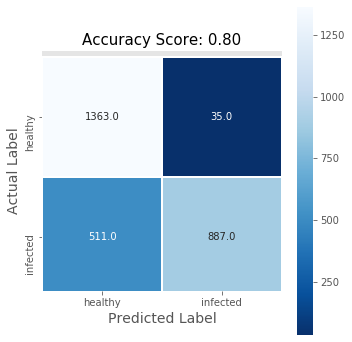

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

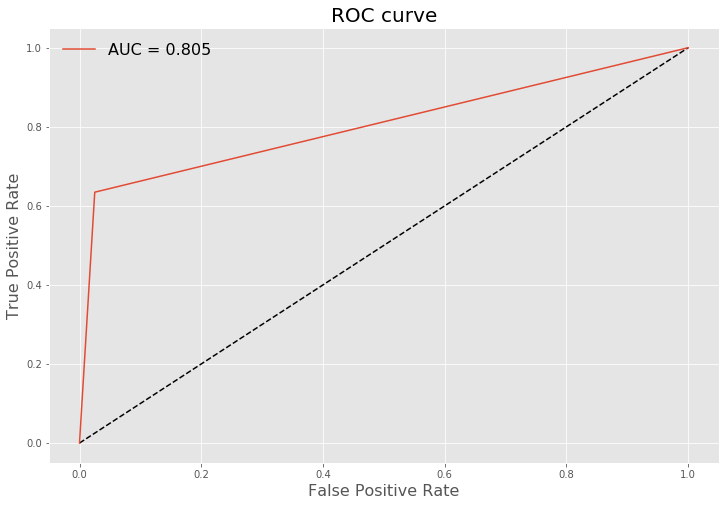

In [26]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

#  fine-tuning

In [27]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [28]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [55]:
history_02 = model_02.fit_generator(train_generator,
                                 steps_per_epoch=10,
                                 epochs=10,
                                 callbacks = [es, cp, lrr],
                                 validation_data = valid_generator)

Epoch 1/10
 9/10 [==========================>...] - ETA: 8s - loss: 0.6392 - accuracy: 0.6667 
Epoch 00001: val_loss did not improve from 0.44221
10/10 [==============================] - 288s 29s/step - loss: 0.6192 - accuracy: 0.6812 - val_loss: 0.4653 - val_accuracy: 0.7405
Epoch 2/10
 9/10 [==========================>...] - ETA: 8s - loss: 0.5483 - accuracy: 0.7222 
Epoch 00002: val_loss did not improve from 0.44221
10/10 [==============================] - 323s 32s/step - loss: 0.5421 - accuracy: 0.7344 - val_loss: 0.5323 - val_accuracy: 0.6949
Epoch 3/10
 9/10 [==========================>...] - ETA: 4:36 - loss: 0.6017 - accuracy: 0.7083 
Epoch 00003: val_loss improved from 0.44221 to 0.38923, saving model to best_model.h5
10/10 [==============================] - 3386s 339s/step - loss: 0.5770 - accuracy: 0.7250 - val_loss: 0.3892 - val_accuracy: 0.8037
Epoch 4/10
 9/10 [==========================>...] - ETA: 8s - loss: 0.4586 - accuracy: 0.7812 
Epoch 00004: val_loss improved from

In [56]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

In [ ]:
## Evaluating the model

Validation loss:     0.2250808093866164
Validation accuracy: 0.9246966242790222
Test loss:           0.21191025159293844
Test accuracy:       0.9309728145599365
2796/2796 [==============================] - 324s 116ms/step
              precision    recall  f1-score   support

     healthy       0.89      0.98      0.93      1398
    infected       0.98      0.88      0.93      1398

    accuracy                           0.93      2796
   macro avg       0.94      0.93      0.93      2796
weighted avg       0.94      0.93      0.93      2796



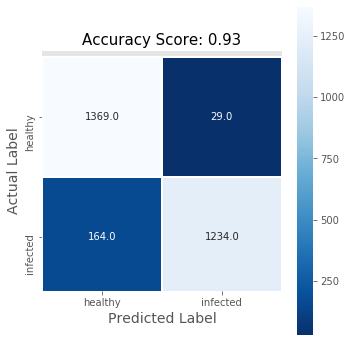

In [43]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate_generator(valid_generator)
vgg_test_eval_02 = model_02.evaluate_generator(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

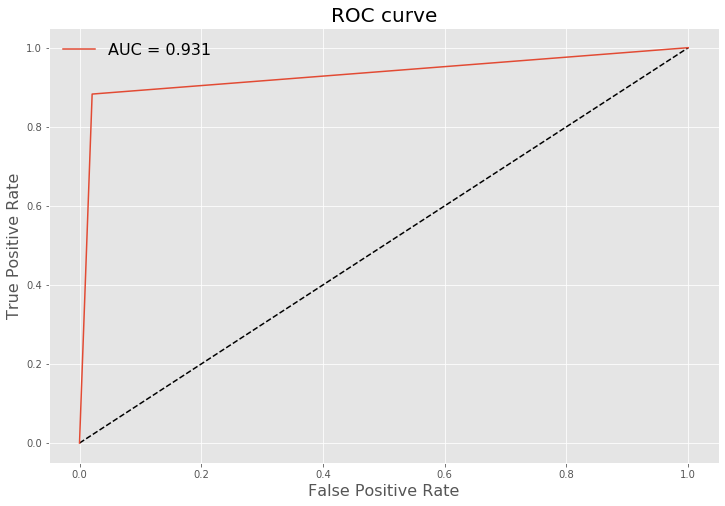

In [40]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Unfreezing and Fine-tuning the entire network

In [55]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history_03 = model_03.fit_generator(train_generator,
                                    steps_per_epoch=100,
                                    epochs=35,
                                    callbacks = [es, cp, lrr],
                                    validation_data = valid_generator)

Epoch 1/35
 99/100 [============================>.] - ETA: 9s - loss: 0.3329 - accuracy: 0.8674 
Epoch 00001: val_loss improved from 0.22547 to 0.17075, saving model to best_model.h5
100/100 [==============================] - 1175s 12s/step - loss: 0.3338 - accuracy: 0.8672 - val_loss: 0.1707 - val_accuracy: 0.9429
Epoch 2/35
 99/100 [============================>.] - ETA: 10s - loss: 0.3099 - accuracy: 0.8795
Epoch 00002: val_loss did not improve from 0.17075
100/100 [==============================] - 1375s 14s/step - loss: 0.3090 - accuracy: 0.8800 - val_loss: 0.1716 - val_accuracy: 0.9433
Epoch 3/35
 99/100 [============================>.] - ETA: 10s - loss: 0.2868 - accuracy: 0.8876
Epoch 00003: val_loss improved from 0.17075 to 0.16279, saving model to best_model.h5
100/100 [==============================] - 1309s 13s/step - loss: 0.2881 - accuracy: 0.8872 - val_loss: 0.1628 - val_accuracy: 0.9465
Epoch 4/35
 99/100 [============================>.] - ETA: 18s - loss: 0.3118 - accu

In [60]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)

## Evaluating the model

Validation loss     :0.18
Validation accuracy :0.95
Test loss           :0.16
Test accuracy       :0.96
2796/2796 [==============================] - 355s 127ms/step
              precision    recall  f1-score   support

     healthy       0.93      0.99      0.96      1398
    infected       0.99      0.93      0.96      1398

    accuracy                           0.96      2796
   macro avg       0.96      0.96      0.96      2796
weighted avg       0.96      0.96      0.96      2796



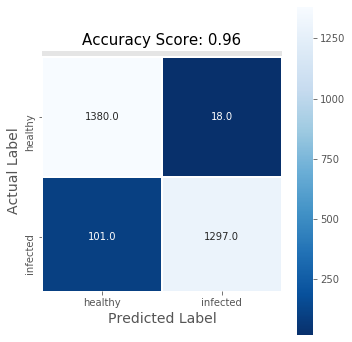

In [60]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate_generator(valid_generator)
vgg_test_eval_03 = model_03.evaluate_generator(test_generator)

print('Validation loss     :{0:.2f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.2f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.2f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.2f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

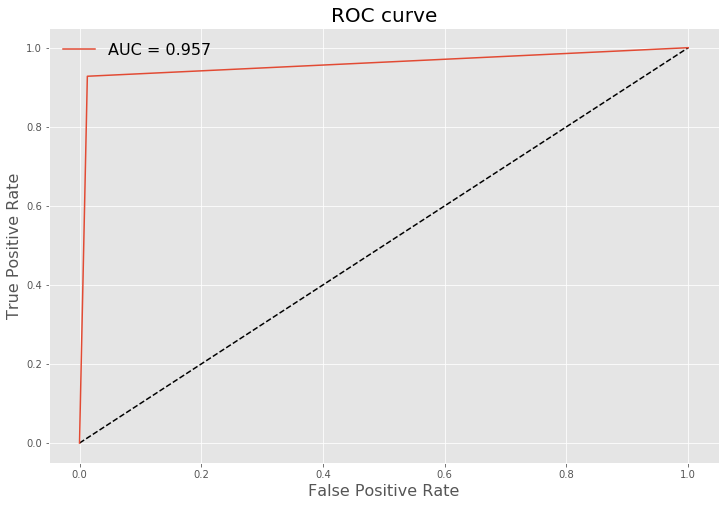

In [41]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Prediction Results for 10 randomly selected images

In [135]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

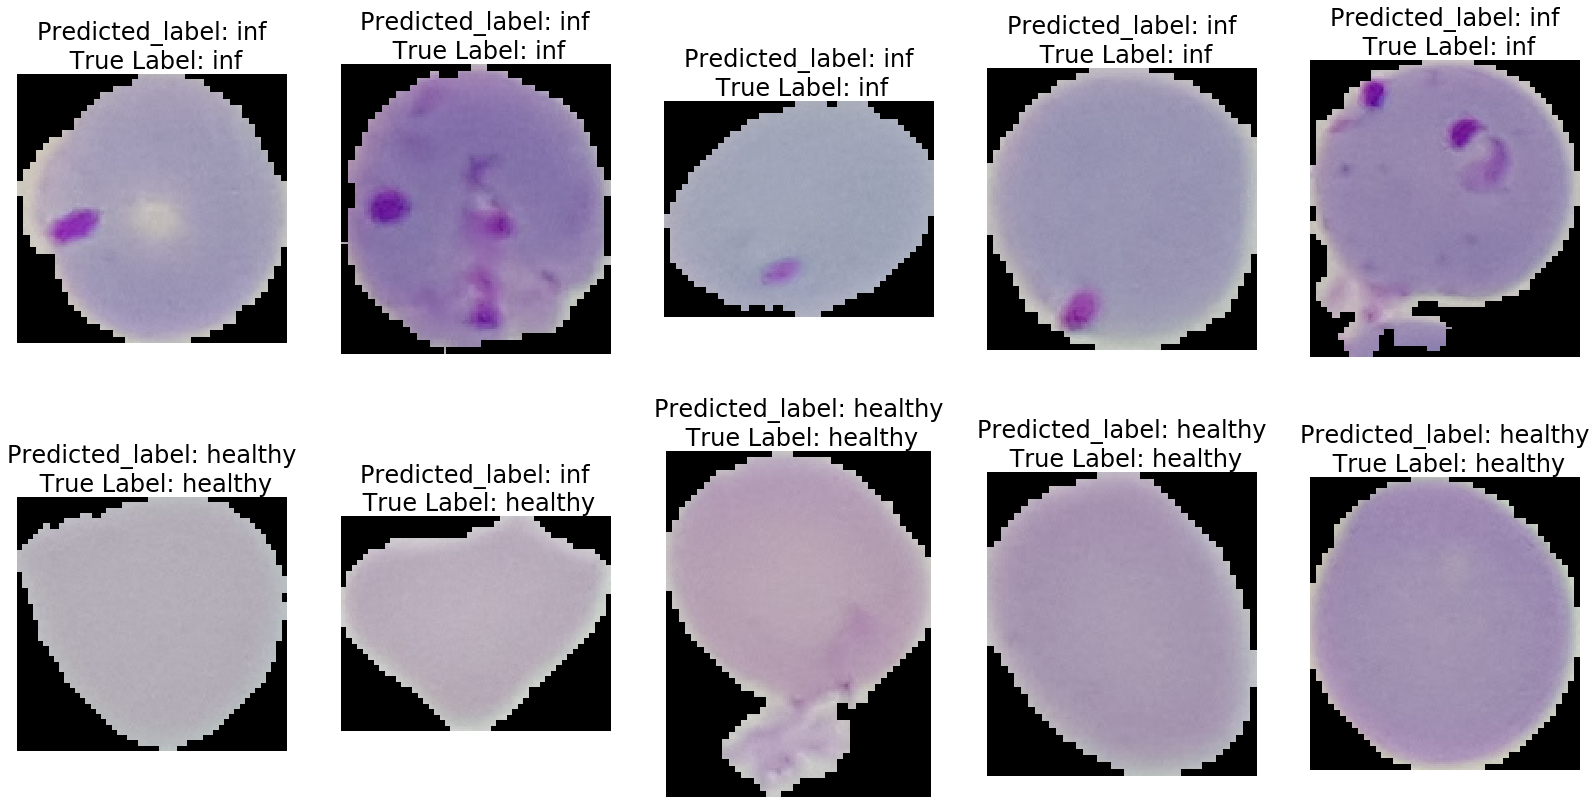

In [137]:
true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[7])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    img = image.load_img(test_images[i-1], target_size=(128,128))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=24)
plt.show()

# Interpretable the classifier with LIME for Image Classification

In [159]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


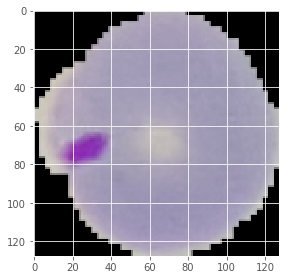

In [160]:
test_image = skimage.io.imread(test_images[0])
test_image = skimage.transform.resize(test_image, (128,128))
skimage.io.imshow(test_image)

# img = image.load_img(test_images[i-1], target_size=(128,128))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis = 0)
# prediction = model_03.predict(img)
# prediction

In [161]:
explainer = lime_image.LimeImageExplainer()

In [162]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_image, model_03.predict, top_labels=1, hide_color=0)

CPU times: user 7min 1s, sys: 35.8 s, total: 7min 37s
Wall time: 1min 36s


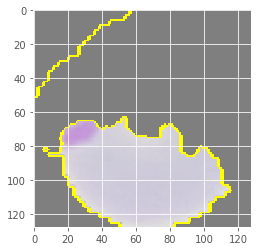

In [163]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

##This notebook is prepared by **Rajesh Arasada**

**Refrences:**
    1. Deep Learning with Python: François Chollet
    
    2. Malaria Detection - Deep Learning Healthcare Case-Study https://github.com/dipanjanS/data_science_for_all/blob/master/os_malaria_detection/Malaria%20Detection%20-%20Deep%20Learning%20Healthcare%20Case-Study.ipynb
    
    3. LIME Tutorial https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb
     